<h1 align="center">📖 Introduction 📖</h1>

<div class="alert alert-block" style="font-size:20px; font-family:verdana; line-height:1.7em; border-radius:20px; padding:2em; background-color:#212021; color: #c4c2c4">
  <img src="assets/insurance.jpg" style="float: right; margin-left: 20px; width: 500px;">
  Insurance is an essential financial service that provides protection against unforeseen risks, offering peace of mind to individuals and businesses. One of the central challenges in the insurance industry is determining the Premium Amount—the cost charged to customers in exchange for coverage. Setting the right premium requires a careful balance: it should reflect the risk associated with the insured entity while remaining competitive and fair.
  </br></br>
  The prediction of the Premium Amount is influenced by numerous factors, such as customer demographics, claim histories, and the specific attributes of the insured item (e.g., vehicle type, property details). This problem is inherently complex due to the interactions between these features and the need to minimize both underpricing (leading to losses for the insurer) and overpricing (causing customers to look elsewhere).
  </br></br>
  In this notebook, we will analyze the dataset to uncover patterns and relationships that drive premium calculations. Through this exploration, we aim to develop a deeper understanding of the variables at play, identify key drivers of the Premium Amount, and set the stage for building predictive models that can assist in accurate pricing strategies.
  </br></br>
  Let’s delve into the data and tackle this fascinating insurance problem!
</div>

<h1 align="center">🔬 Feature Description 🔬</h1>

<div class="alert alert-block" style="font-size:20px; font-family:verdana; line-height:1.7em; border-radius:20px; padding:2em; background-color:#212021; color: #c4c2c4;">
Here’s a brief feature description list for both the <strong>Train</strong> and the <strong>Test</strong> datasets combined:</br>
<ol>
<li><strong>Gender</strong>: Participant's gender.</li>
<li><strong>Age</strong>: Participant's age, ranging from 18 to 64, with a mean of 41, allowing age-based insights.</li>
<li><strong>Annual Income</strong>: Yearly income ranging from 1 to 149,997, with a mean of 32,768.</li>
<li><strong>Marital Status</strong>: Represents participants' marital status, categorized as <strong>Single</strong>, <strong>Married</strong>, or <strong>Divorced</strong>.</li>
<li><strong>Number of Dependents</strong>: Refers to individuals financially supported by the participant, ranging from 0 to 4, with a mean of 2.</li>
<li><strong>Education Level</strong>: Represents participants' highest level of education, including <strong>Master's</strong>, <strong>PhD</strong>, <strong>Bachelor's</strong>, and <strong>High School</strong>.</li>
<li><strong>Occupation</strong>: Represents the participant's employment status, including <strong>Employed</strong>, <strong>Self-Employed</strong>, and <strong>Unemployed</strong>.</li>
<li><strong>Health Score</strong>: Represents the participant's health rating, ranging from 1 to 58, with a mean of 24.</li>
<li><strong>Location</strong>: Represents the participant's living area, categorized as <strong>Suburban</strong>, <strong>Rural</strong>, or <strong>Urban</strong>.</li>
<li><strong>Policy Type</strong>: Represents the type of insurance policy, categorized as <strong>Premium</strong>, <strong>Comprehensive</strong>, or <strong>Basic</strong>.</li>
<li><strong>Policy Start Date</strong>: Represents the date the participant's policy started, ranging from 2019 to 2024, with a mean of 2021.</li>
<li><strong>Previous Claims</strong>: Represents the number of previous claims made by the participant, ranging from 0 to 9, with a mean of 1.</li>
<li><strong>Vehicle Age</strong>: Represents the age of the participant's vehicle, ranging from 0 to 19 years, with a mean of 9.</li>
<li><strong>Credit Score</strong>: Represents the participant's credit score, ranging from 300 to 849, with a mean of 592.</li>
<li><strong>Insurance Duration</strong>: Represents the duration of the insurance policy, ranging from 1 to 9 years, with a mean of 5.</li>
<li><strong>Customer Feedback</strong>: Represents the participant's feedback on the service, categorized as <strong>Poor</strong>, <strong>Average</strong>, or <strong>Good</strong>.</li>
<li><strong>Smoking Status</strong>: Represents whether the participant smokes, categorized as <strong>Yes</strong> or <strong>No</strong>.</li>
<li><strong>Exercise Frequency</strong>: Represents how often the participant exercises, categorized as <strong>Rarely</strong>, <strong>Daily</strong>, <strong>Weekly</strong>, or <strong>Montlhy</strong>.</li>
<li><strong>Property Type</strong>: Represents the type of property the participant resides in, categorized as <strong>House</strong>, <strong>Condo</strong>, or <strong>Apartment</strong>.</li>
</ol>
<strong>Target Variable</strong></br>
<ul>
<li><strong>Premium Amount</strong>: Represents the insurance premium amount for the participant, ranging from 20 to 4,999, based on various factors.</li>
</ul>
</div>


<h1 align="center">🎯 Target 🎯</h1>

<div class="alert alert-block alert-danger" style="font-size:20px; font-family:verdana; line-height:1.7em; background-color:#212021; border-radius:2em; padding:2em;">
    The target of this project is to develop predictive models that accurately estimate the insurance premium amount for individuals based on a variety of demographic, lifestyle, and personal factors. By analyzing this dataset, we aim to:</br>
    <ol>
        <li><strong>Identify Key Factors</strong>: Discover which variables—such as age, marital status, education level, occupation, credit score, health status, and more—most strongly influence the premium amount.</li>
        <li><strong>Build a Predictive Model</strong>: Use machine learning techniques to create a model that can predict an individual's insurance premium amount, given their personal and lifestyle information.</li>
        <li><strong>Gain Business Insights</strong>: Understand the patterns and trends that impact premium pricing, which can help insurance companies optimize their offerings and improve customer segmentation strategies.</li>
    </ol>
    Ultimately, this project seeks to demonstrate how machine learning can assist in the insurance industry by identifying key factors influencing premiums, offering valuable insights to help in pricing strategies and customer targeting.
</div>


  <center><h1>🎉 Fun Fact 🎉</h1></center>

<div class="alert alert-block alert-info" style="font-size:20px; font-family:verdana; line-height:1.7em; background-color:#f0f8ff; border-radius:2em; padding:2em;">
  The word "premium" is derived from the Latin word <i>praemium</i>, which meant "reward" or "prize." So, every time you pay your insurance premium, you're actually investing in a <i>"reward"</i> or <i>"prize"</i> for future protection!
</div>

<h1 align="center">📚 Importing Libraries 📚</h1>

In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h1 align="center">🖨️ Import Data 🖨️</h1>

In [297]:
train_path = './data/train.csv'
test_path = './data/test.csv'
origin_path = './data/origin.csv'

In [298]:
train_df = pd.read_csv(train_path, index_col='id')
test_df = pd.read_csv(test_path, index_col='id')
origin_df = pd.read_csv(origin_path)

In [299]:
print("Train Shape: ", train_df.shape)
print("Test Shape: ", test_df.shape)
print("Origin Shape: ", origin_df.shape)

Train Shape:  (1200000, 20)
Test Shape:  (800000, 19)
Origin Shape:  (278860, 20)


In [300]:
df = pd.concat([train_df, origin_df], sort=False)

In [301]:
df.columns

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [302]:
df.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [303]:
origin_df.isna().sum()[origin_df.isna().sum() > 0].sort_values(ascending=False)

Occupation              81288
Previous Claims         81288
Number of Dependents    27886
Credit Score            27886
Customer Feedback       18349
Annual Income           13955
Health Score            10597
Marital Status           5019
Age                      4685
Premium Amount           1841
dtype: int64

In [304]:
test_df.isna().sum()[test_df.isna().sum() > 0].sort_values(ascending=False)


Previous Claims         242802
Occupation              239125
Credit Score             91451
Number of Dependents     73130
Customer Feedback        52276
Health Score             49449
Annual Income            29860
Age                      12489
Marital Status           12336
Vehicle Age                  3
Insurance Duration           2
dtype: int64

In [305]:
train_df = pd.concat([train_df, origin_df]).reset_index(drop=True)

In [306]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478860 entries, 0 to 1478859
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1455470 non-null  float64
 1   Gender                1478860 non-null  object 
 2   Annual Income         1419956 non-null  float64
 3   Marital Status        1455312 non-null  object 
 4   Number of Dependents  1341302 non-null  float64
 5   Education Level       1478860 non-null  object 
 6   Occupation            1039497 non-null  object 
 7   Health Score          1394187 non-null  float64
 8   Location              1478860 non-null  object 
 9   Policy Type           1478860 non-null  object 
 10  Previous Claims       1033543 non-null  float64
 11  Vehicle Age           1478854 non-null  float64
 12  Credit Score          1313092 non-null  float64
 13  Insurance Duration    1478859 non-null  float64
 14  Policy Start Date     1478860 non-

<h1 align="center">📊 EDA 📈</h1>

In [307]:
target = 'Premium Amount'

We will use the list `added_features` to keep track of all newly created columns (features).

In [308]:
added_features = []

In [309]:
train_df['Policy Start Date'] = pd.to_datetime(train_df['Policy Start Date'])

train_df['Policy Start Year'] = train_df['Policy Start Date'].dt.year
train_df['Policy Start Month'] = train_df['Policy Start Date'].dt.month
train_df['Policy Start Day'] = train_df['Policy Start Date'].dt.day

In [310]:
added_features.extend(['Policy Start Day', 'Policy Start Month', 'Policy Start Year'])
added_features

['Policy Start Day', 'Policy Start Month', 'Policy Start Year']

In [311]:
features = train_df.drop(target, axis=1).columns.to_list()
features

['Age',
 'Gender',
 'Annual Income',
 'Marital Status',
 'Number of Dependents',
 'Education Level',
 'Occupation',
 'Health Score',
 'Location',
 'Policy Type',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration',
 'Policy Start Date',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type',
 'Policy Start Year',
 'Policy Start Month',
 'Policy Start Day']

In [312]:
numerical_features = train_df.drop(target, axis=1).select_dtypes(include=[np.number]).columns.to_list()
numerical_features

['Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration',
 'Policy Start Year',
 'Policy Start Month',
 'Policy Start Day']

In [313]:
categorical_features = train_df.drop(target, axis=1).select_dtypes(exclude=[np.number]).columns.to_list()
categorical_features

['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Policy Start Date',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type']

In [314]:
train_df[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1455470.0,41.122055,13.541867,18.000000,29.000000,41.000000,53.000000,64.00000
Annual Income,1419956.0,34488.396603,33014.542180,0.000000,9068.000000,24996.000000,46313.000000,149997.00000
Number of Dependents,1341302.0,2.007710,1.416406,0.000000,1.000000,2.000000,3.000000,4.00000
Health Score,1394187.0,26.185455,13.064857,0.035436,15.937196,24.849282,35.242599,93.87609
Previous Claims,1033543.0,1.001815,0.986299,0.000000,0.000000,1.000000,2.000000,9.00000
Vehicle Age,1478854.0,9.560535,5.774660,0.000000,5.000000,10.000000,15.000000,19.00000
Credit Score,1313092.0,589.376499,151.880795,300.000000,463.000000,591.000000,719.000000,849.00000
Insurance Duration,1478859.0,5.016248,2.591891,1.000000,3.000000,5.000000,7.000000,9.00000
Policy Start Year,1478860.0,2021.621955,1.479317,2019.000000,2020.000000,2022.000000,2023.000000,2024.00000
Policy Start Month,1478860.0,6.496173,3.435071,1.000000,4.000000,6.000000,9.000000,12.00000


In [315]:
train_df[categorical_features].describe(include='O').T

,count,unique,top,freq
Gender,1478860,2,Male,742325
Marital Status,1455312,3,Single,486888
Education Level,1478860,4,Master's,373633
Occupation,1039497,3,Employed,348649
Location,1478860,3,Suburban,495024
Policy Type,1478860,3,Premium,495144
Customer Feedback,1382687,3,Average,464811
Smoking Status,1478860,2,Yes,741508
Exercise Frequency,1478860,4,Weekly,376417
Property Type,1478860,3,House,493577


<h2 align="center">Missing Data Check 🔍</h2>

In [316]:
train_null_df = pd.DataFrame({
    'column': train_df.columns,
    'null': train_df.isna().sum().values,
    '% null': np.round(train_df.isna().sum().values*100/len(train_df),6)
}).sort_values(by='null', ascending=False).reset_index(drop=True)

train_null_df = train_null_df[train_null_df['null'] != 0]
train_null_df

,column,null,% null
0,Previous Claims,445317,30.112181
1,Occupation,439363,29.709574
2,Credit Score,165768,11.209175
3,Number of Dependents,137558,9.301624
4,Customer Feedback,96173,6.503185
5,Health Score,84673,5.725559
6,Annual Income,58904,3.983068
7,Marital Status,23548,1.592308
8,Age,23390,1.581624
9,Premium Amount,1841,0.124488


From the table above we can see **1841** missing values from the ```Premium Amount```, so we will move them to the test_df

In [317]:
premium_amount_null_rows = train_df[train_df['Premium Amount'].isna()]
premium_amount_null_rows = premium_amount_null_rows.drop(columns=['Premium Amount'] + added_features)

premium_amount_null_rows.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
1200222,34.0,Female,82572.0,Married,4.0,PhD,Self-Employed,NaN,Urban,Basic,2.0,15.0,449.0,2.0,2021-07-10 15:21:39.079026,Average,No,Rarely,Apartment
1200486,62.0,Male,36868.0,Single,0.0,Master's,Employed,17.957143,Rural,Comprehensive,1.0,17.0,796.0,3.0,2022-02-28 15:21:39.079128,Good,No,Monthly,Condo
1200715,19.0,Male,51425.0,Married,NaN,PhD,Unemployed,22.439690,Suburban,Basic,0.0,19.0,429.0,7.0,2021-06-10 15:21:39.079128,Poor,No,Daily,House
1200869,25.0,Male,9257.0,Divorced,4.0,Bachelor's,Self-Employed,12.259131,Urban,Comprehensive,4.0,18.0,519.0,3.0,2020-07-25 15:21:39.079128,Good,No,Monthly,House
1200973,23.0,Female,22200.0,Single,1.0,PhD,NaN,11.723279,Rural,Basic,1.0,14.0,480.0,8.0,2020-06-10 15:21:39.079128,Poor,Yes,Rarely,Condo


In [318]:
train_df = train_df[~train_df['Premium Amount'].isna()]
test_df = pd.concat([test_df, premium_amount_null_rows], ignore_index=True)

In [319]:
test_null_df = pd.DataFrame({
    'column': test_df.columns,
    'null': test_df.isna().sum().values,
    '% null': np.round(test_df.isna().sum().values*100/len(test_df),6)
}).sort_values(by='null', ascending=False).reset_index(drop=True)

test_null_df = test_null_df[test_null_df['null'] != 0]
test_null_df

,column,null,% null
0,Previous Claims,243341,30.347787
1,Occupation,239665,29.889342
2,Credit Score,91637,11.428326
3,Number of Dependents,73327,9.144830
4,Customer Feedback,52367,6.530846
5,Health Score,49521,6.175913
6,Annual Income,29964,3.736900
7,Age,12516,1.560908
8,Marital Status,12364,1.541952
9,Vehicle Age,3,0.000374


Update `train_null_df` by moving all rows with missing `Premium Amount` from `train_df` to `test_df`.

In [320]:
train_null_df = pd.DataFrame({
    'column': train_df.columns,
    'null': train_df.isna().sum().values,
    '% null': np.round(train_df.isna().sum().values*100/len(train_df),6)
}).sort_values(by='null', ascending=False).reset_index(drop=True)

train_null_df = train_null_df[train_null_df['null'] != 0]

Here we will check if the missing values are all from the same columns, from both the ```test_df``` and ```train_df```

In [321]:
diff_rows = pd.concat([test_null_df['column'], train_null_df['column']]).drop_duplicates(keep=False)
diff_rows

Series([], Name: column, dtype: object)

<h2 align="center">Duplicate Check 🔍</h2>

In [322]:
train_df.duplicated().sum()

0

<h2 align="center">Distribution of Numerical Features 📉</h2>

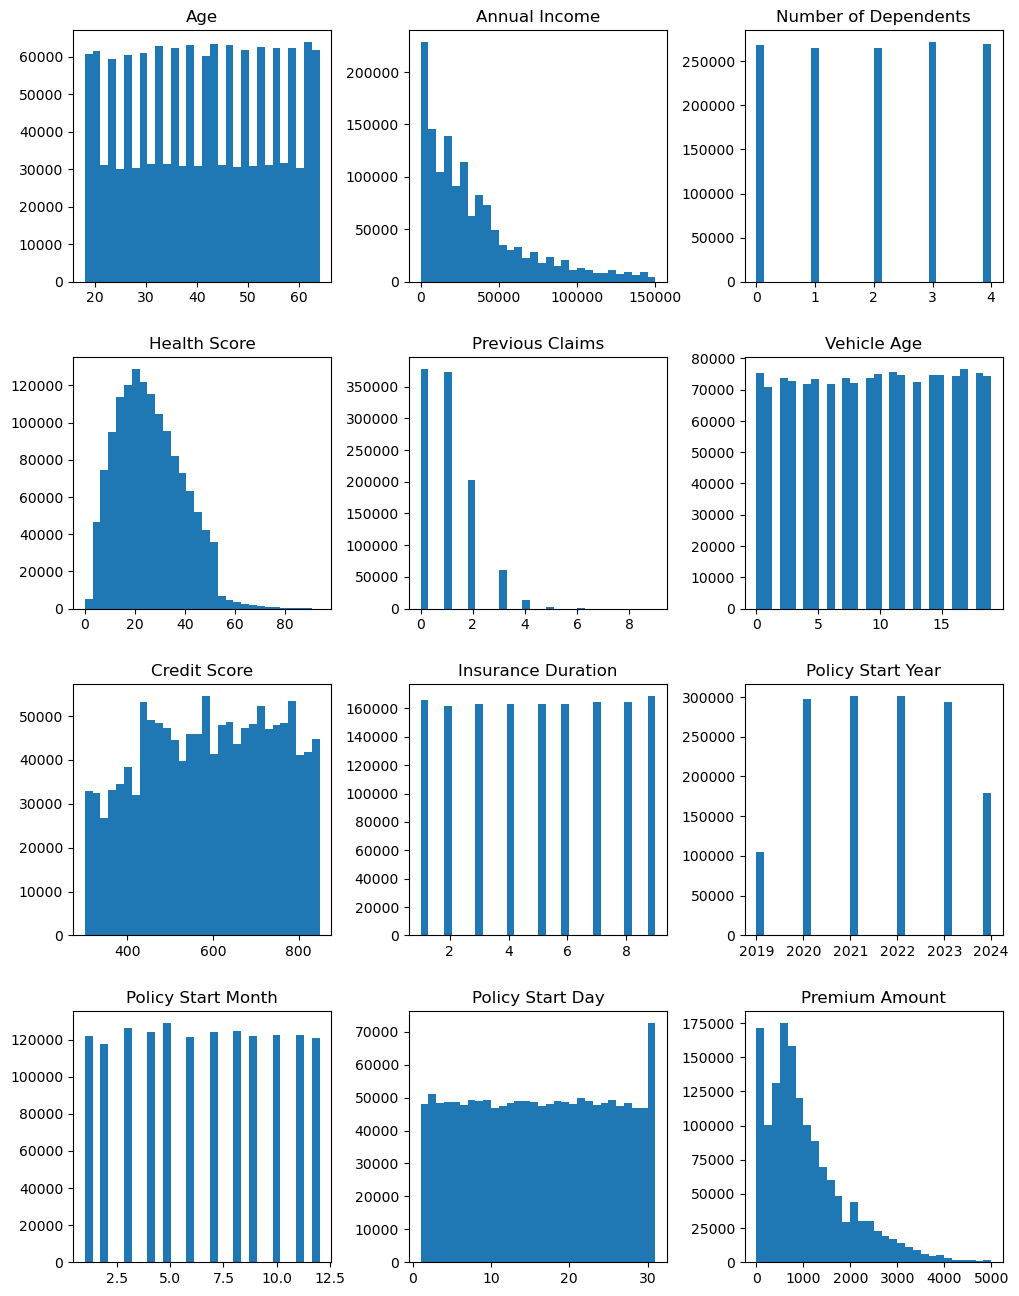

In [323]:
columns_to_plot = numerical_features + [target]

train_df[columns_to_plot].hist(bins=30, figsize=(12, 16), grid=False);

<h2 align="center">Distribution of Categorical Features 📉</h2>

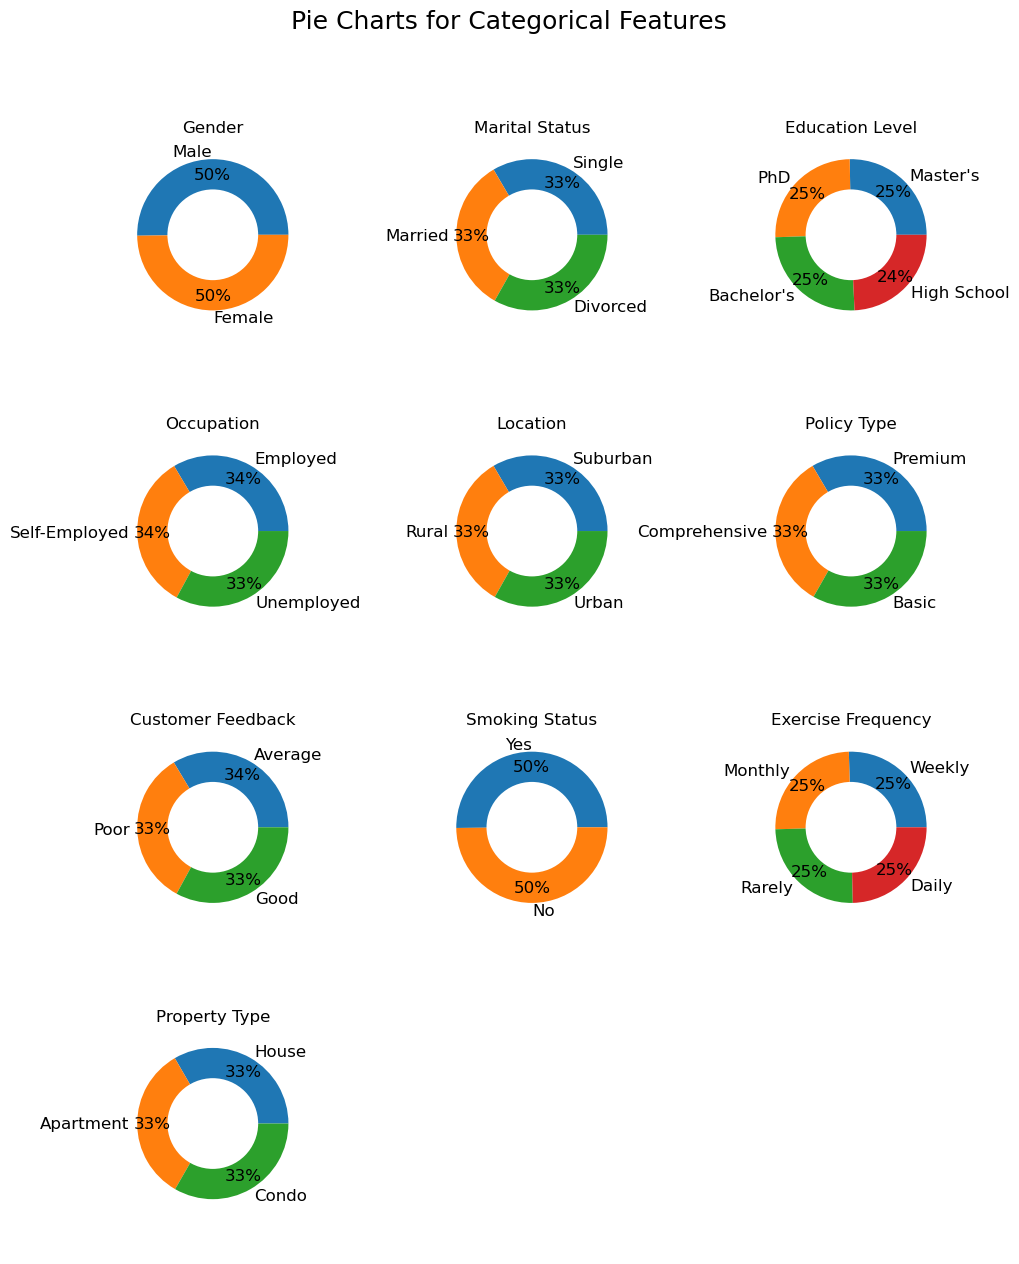

In [324]:
columns_to_plot = categorical_features.copy()
columns_to_plot.remove('Policy Start Date')

num_features = len(columns_to_plot)
rows = (num_features + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(10, rows * 3))
axs = axs.flatten()

for i, col in enumerate(columns_to_plot):
  filtered_data = train_df[col].value_counts() / len(train_df)
  filtered_cat = filtered_data[filtered_data >= 0.03].index
  filtered_df = train_df[train_df[col].isin(filtered_cat)]

  ax = axs[i]
  filtered_df[col].value_counts().plot(kind='pie', autopct='%.0f%%', pctdistance=0.8, fontsize=12, ax=ax)
  ax.add_artist(plt.Circle((0, 0), radius=0.6, fc='white'))
  ax.set_ylabel('')
  ax.set_title(f'{col}')
for j in range(i + 1, len(axs)):
  axs[j].axis('off')

plt.tight_layout()
plt.suptitle("Pie Charts for Categorical Features", y=1.05, size=18)
plt.show()

<h2 align='center'>Target Distribution 🎯</h2>

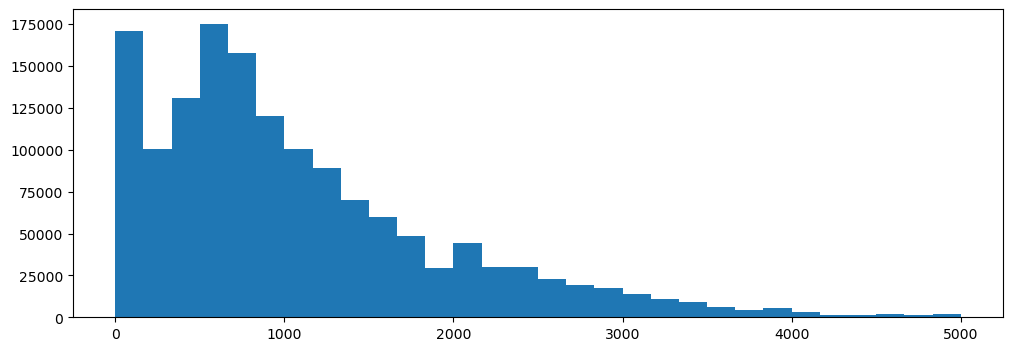

In [325]:
train_df[target].hist(bins=30, figsize=(12, 4), grid=False);

<h2 align="center"> Filling Missing Data ⛑️</h2>

In [326]:
train_null_df

,column,null,% null
0,Previous Claims,444778,30.113221
1,Occupation,438823,29.710044
2,Credit Score,165582,11.210553
3,Number of Dependents,137361,9.299880
4,Customer Feedback,96082,6.505130
5,Health Score,84601,5.727821
6,Annual Income,58800,3.980991
7,Marital Status,23520,1.592397
8,Age,23363,1.581767
9,Vehicle Age,6,0.000406


In [327]:
missing_numerical_columns = train_null_df[train_null_df['column'].isin(numerical_features)]
missing_numerical_columns = missing_numerical_columns['column']

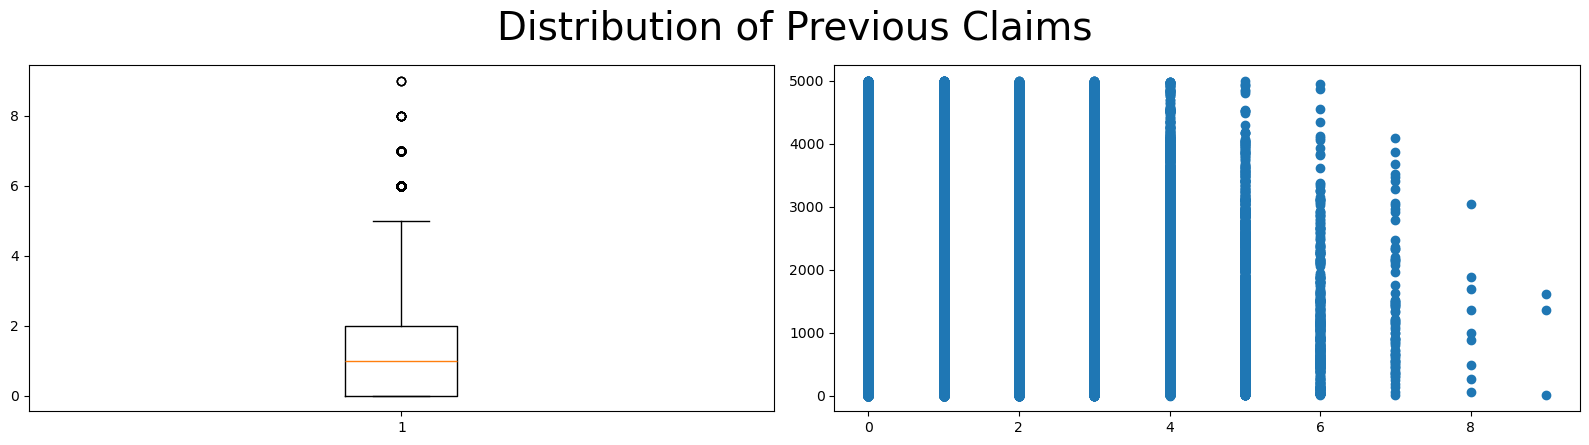

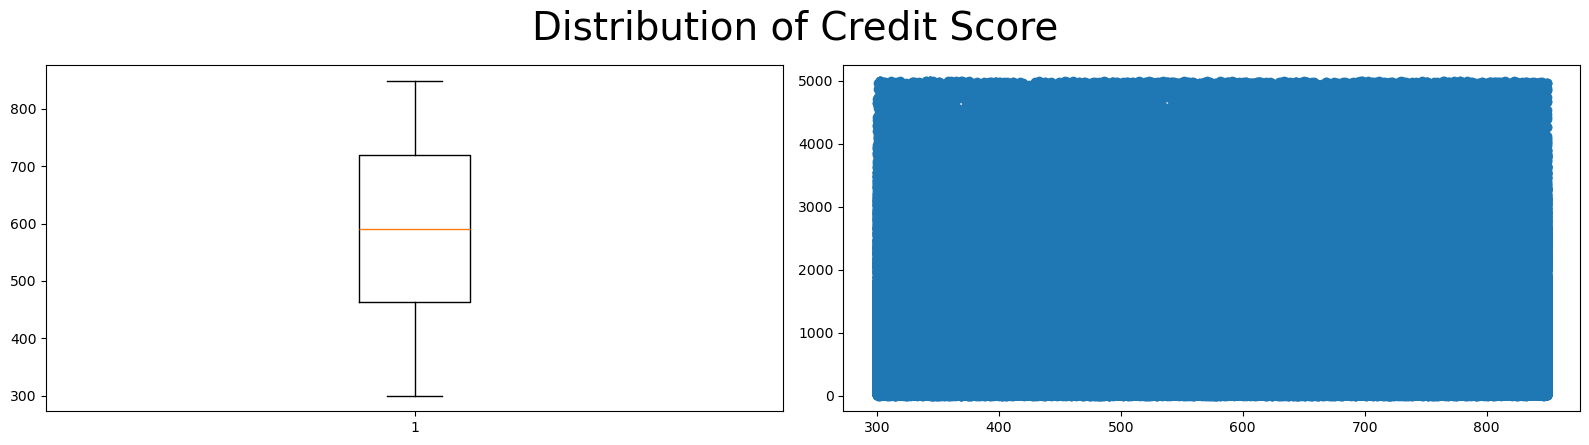

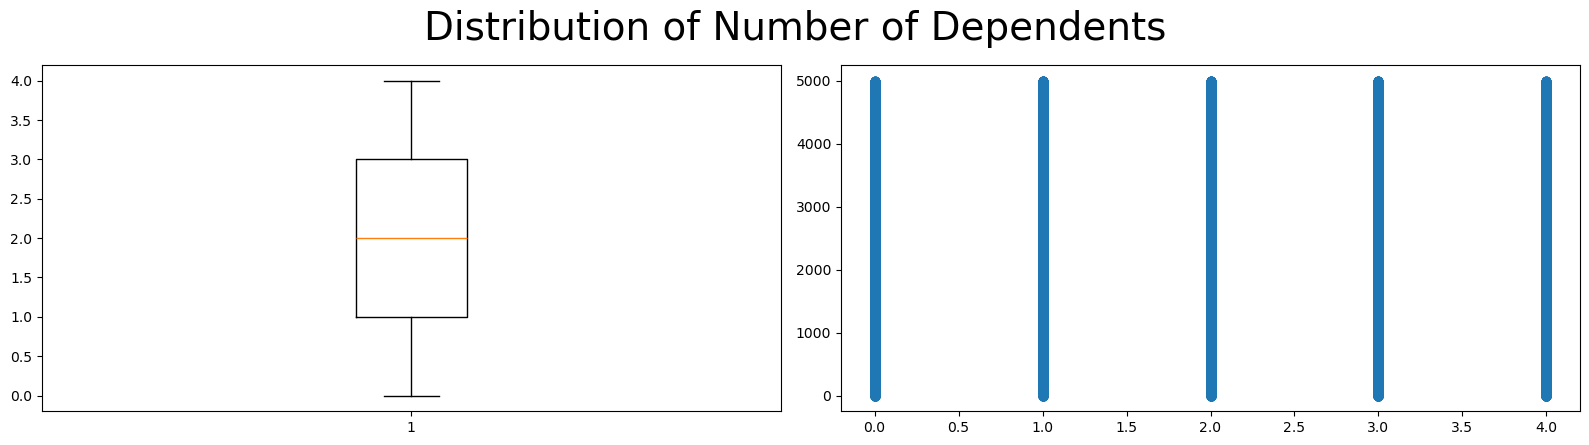

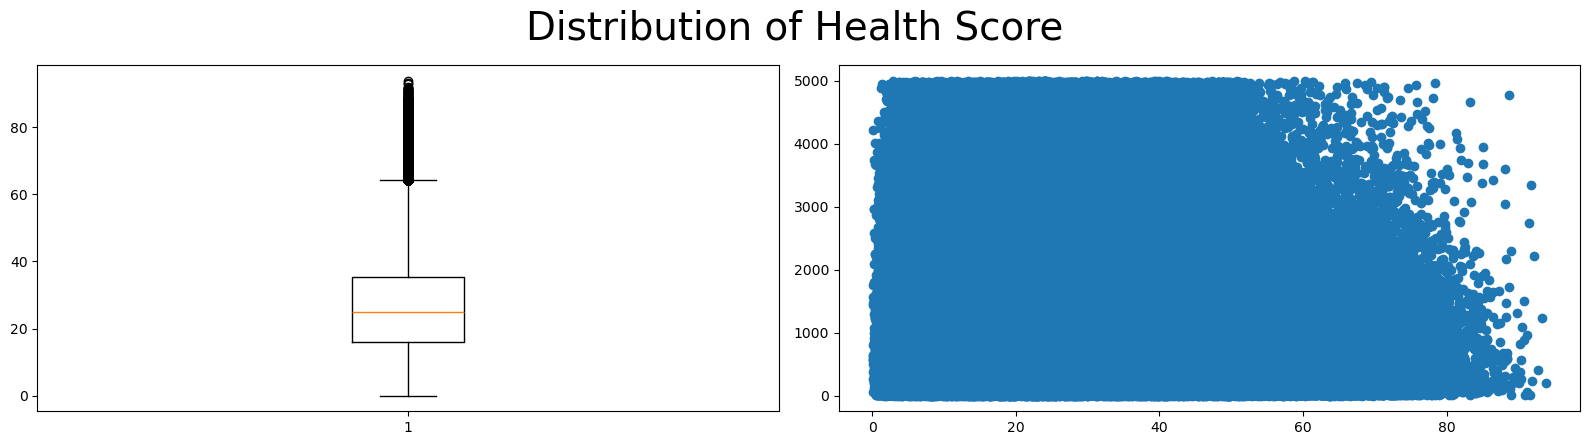

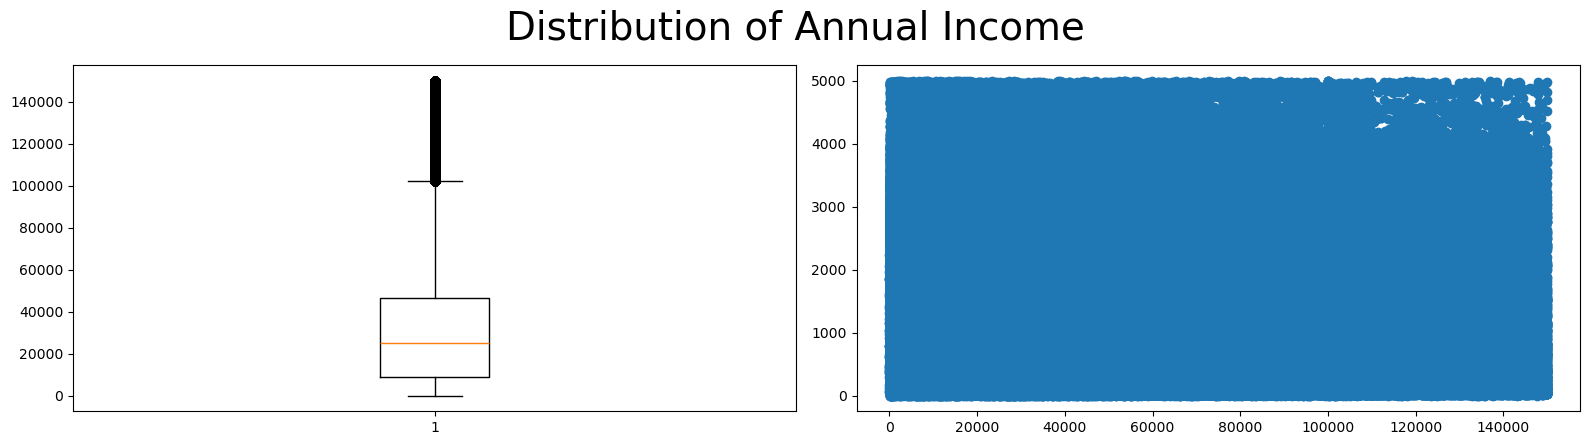

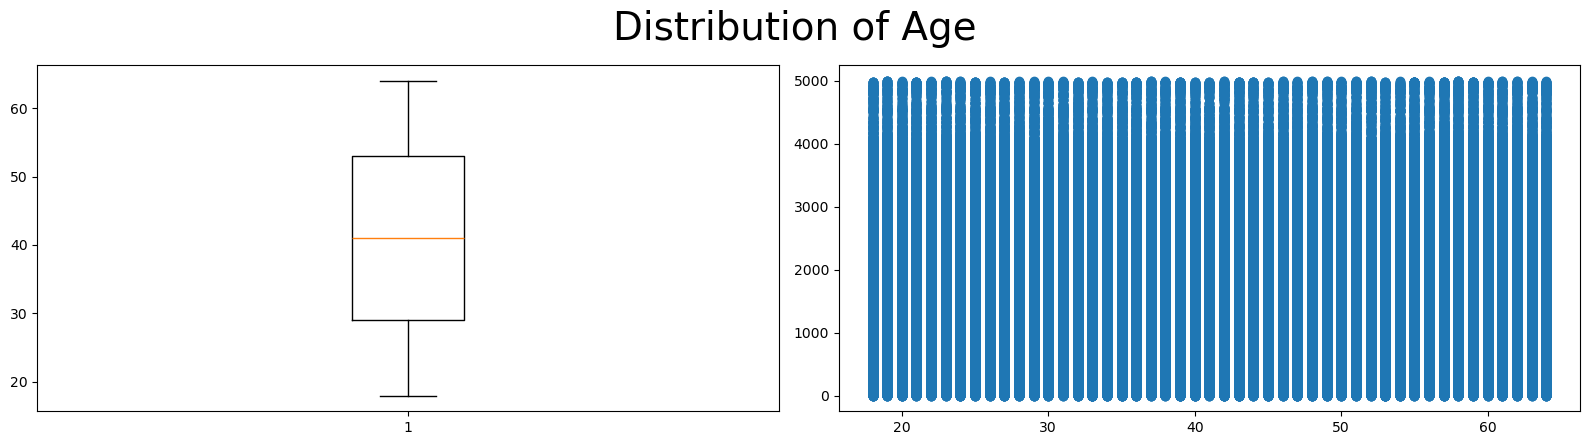

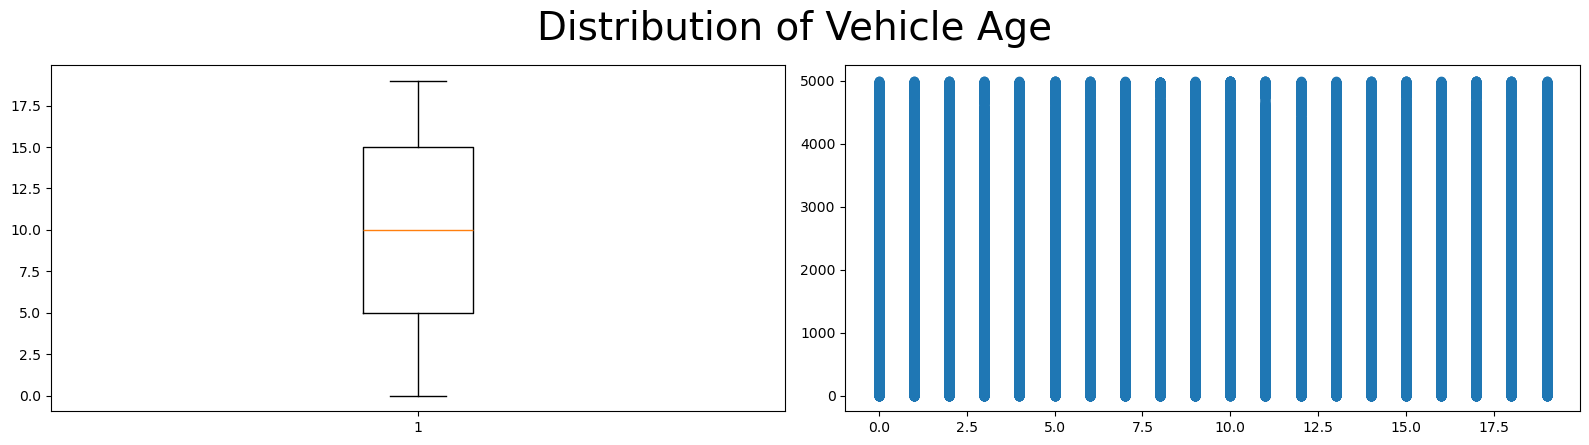

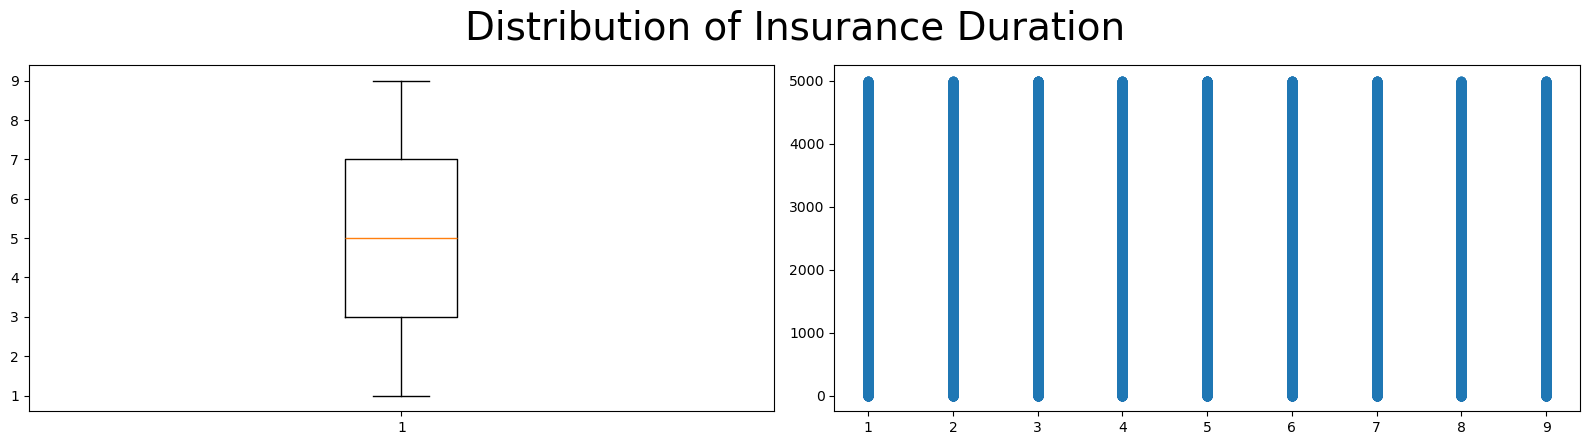

In [328]:
for col in missing_numerical_columns:
  fig, axs = plt.subplots(1, 2, figsize=(16, 4))
  ax = axs.flatten()

  ax[0].boxplot(train_df[col].dropna())
  
  plt.scatter(train_df[col], y=train_df[target])

  plt.tight_layout()
  plt.suptitle(f"Distribution of {col}", y=1.1, size=28)
  plt.show();

<div class="alert alert-block" style="font-size:20px; font-family:verdana; line-height:1.7em; border-radius:20px; padding:2em; background-color:#212021; color: #c4c2c4;">
<strong>INSIGHTS</strong>: From the above plots we can see that we have <strong>outliers</strong> in the <code>Previous Claims</code>, <code>Health Score</code> and <code>Annual 
Income</code> column.

<code>Annual Income</code>:
Outliers in <strong>Annual Income</strong> should <strong>not be fixed</strong>. Higher income typically correlates with higher premiums, which is logical.

<code>Health Score</code>:
Outliers in <strong>Health Score</strong> should be <strong>fixed</strong>. A higher health score usually leads to a lower premium, so extreme values may indicate errors that could distort pricing.

<code>Previous Claims</code>:
Outliers in <strong>Previous Claims</strong> should also be <strong>fixed</strong>. Extreme values can distort risk assessment and premium calculations.
</div>

<h2 align="center"> Handling Outliers 🛠️<h2>

In [329]:
def get_boundaries(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  return lower_bound, upper_bound

In [330]:
health_lower_bound, health_upper_bound = get_boundaries(train_df, 'Health Score')
previous_claims_lower_bound, previous_claims_upper_bound = get_boundaries(train_df, 'Previous Claims')

In [331]:
train_df['Health Score'] = train_df['Health Score'].clip(lower=health_lower_bound, upper=health_upper_bound)
train_df['Previous Claims'] = train_df['Previous Claims'].clip(lower=previous_claims_lower_bound, upper=previous_claims_upper_bound)

<h2 align="center"> Numerical Correlation 🪢</h2>

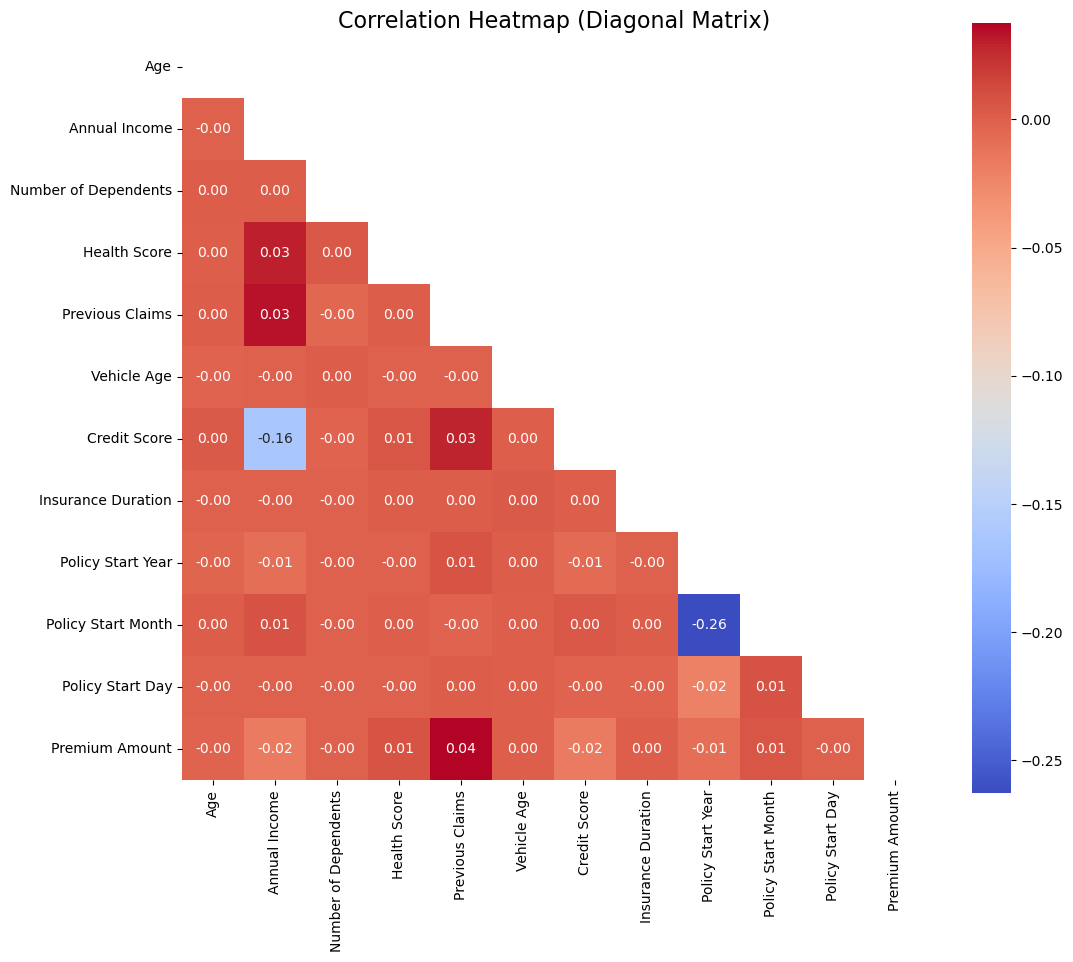

In [73]:
columns = numerical_features.copy() + [target]
correlation_matrix = train_df[columns].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, mask=np.triu(np.ones(correlation_matrix.shape)))

plt.title("Correlation Heatmap (Diagonal Matrix)", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

<h2 align="center"> Categorical Correlation 🪢</h2>

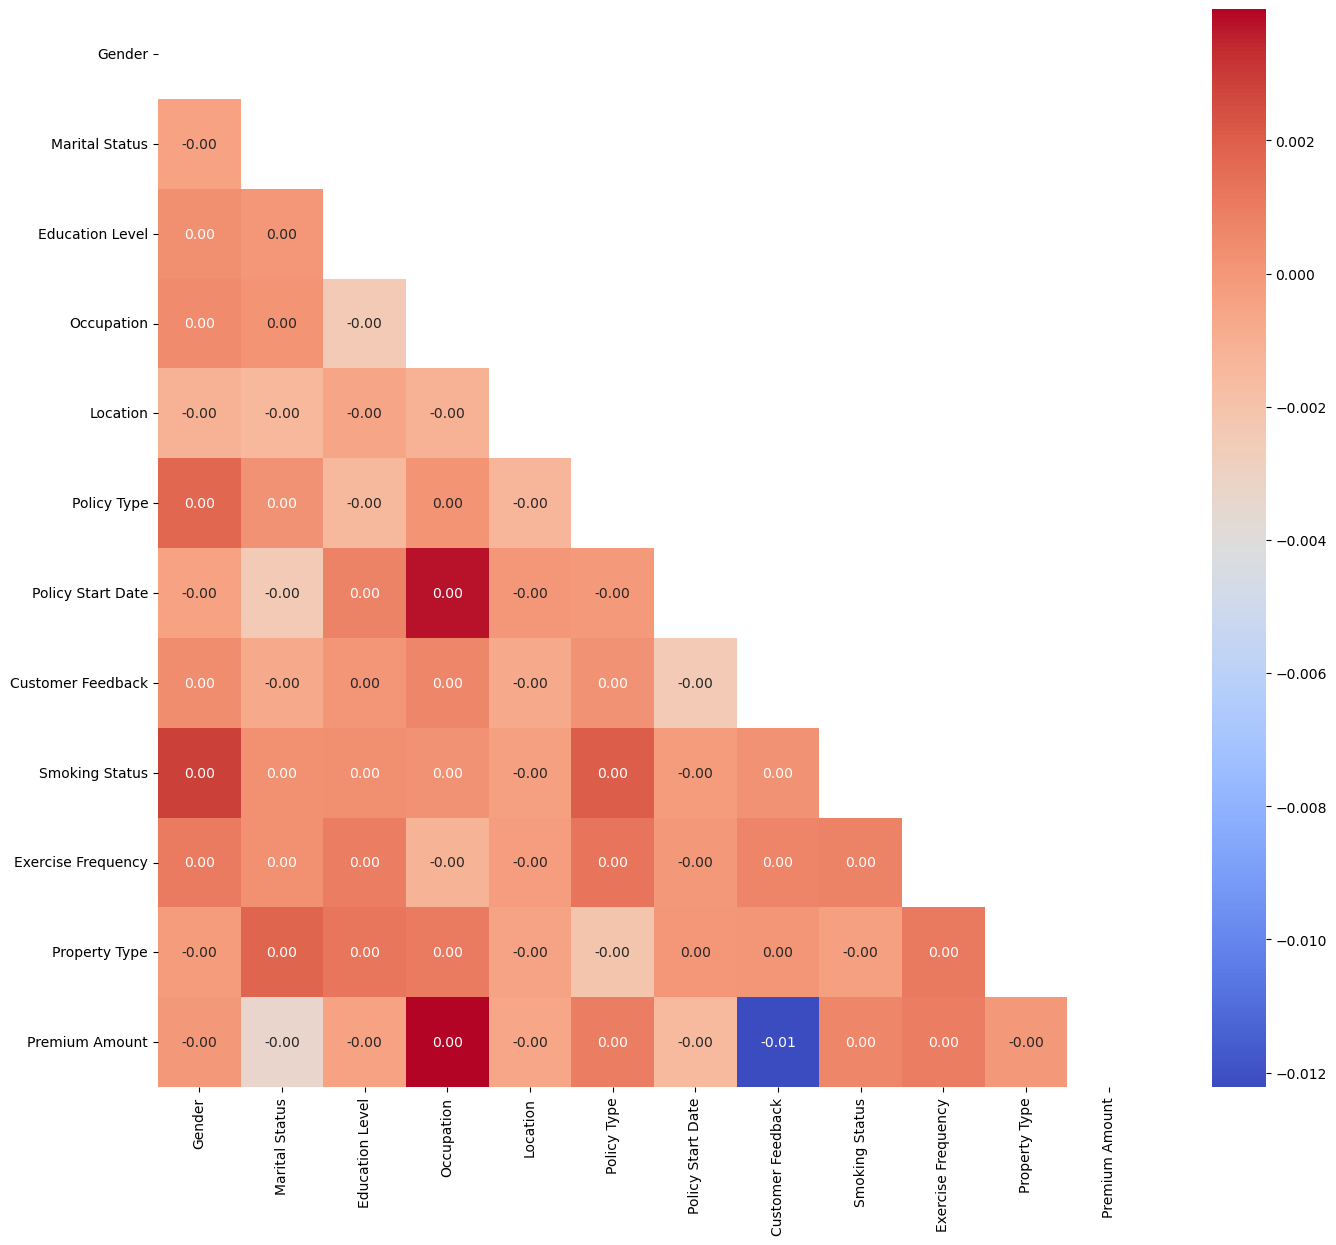

In [76]:
train_cr = train_df.copy()

for col in categorical_features:
    train_cr[col], _ = train_cr[col].factorize()

columns = categorical_features.copy() + [target]

cor_mat = train_cr[columns].corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(16, 14))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.show()